In [ ]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import seaborn as sns
import pickle

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
from exp_spatialdm import spatialdm
from matplotlib import pyplot as plt
import warnings


warnings.filterwarnings('ignore')
pre_datapath = "../../output/preprocessed_dataset/mouseliver.pkl"
spec = "mouse"
ST_name = "mouseliver5fold"
seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
with open(pre_datapath, 'rb') as infile:
    spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)

cls_key = 'leiden'
classes = scrna_adata.obs[cls_key]
ct_list = np.unique(classes)    

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

test_gene_set = []
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpLR = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_gene_set.append(test_gene)
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpLR[test_gene] = expTransImp(
                    df_ref=raw_scrna_df,
                    df_tgt=raw_spatial_df,
                    train_gene=train_gene,
                    test_gene=test_gene,
                    signature_mode='cell',
                    mapping_mode='lowrank',
                    n_epochs=2000,
                    seed=seed,
                    device=device
    )
    corr_transImpLR_res = calc_corr(raw_spatial_df, df_transImpLR, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpLR_res)} (TransImpLR)')    
    
    df_transImpSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                n_epochs=2000,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpSpa_res)} (TransImpSpa)')
    
    df_transImpCls[test_gene] = expTransImp(
            df_ref=raw_scrna_df,
            df_tgt=raw_spatial_df,
            train_gene=train_gene,
            test_gene=test_gene,
            ct_list=ct_list,
            classes=classes,
            n_epochs=2000,
            signature_mode='cluster',
            mapping_mode='full',
            seed=seed,
            device=device)

    corr_transImp_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImp_res)} (TransImpCls)')
    
    
    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_9y", verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(scrna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_tangram)} (Tangram)')


===== Fold 1 =====
Number of train genes: 3613, Number of test genes: 904


[TransImp] Epoch: 2000/2000, loss: 0.637367, (IMP) 0.637367: 100%|██████████| 2000/2000 [00:36<00:00, 55.14it/s]


fold 0, median cosine similarity: 0.4938371628522873 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.643409, (IMP) 0.641881, (SPA) 1.0 x 0.001528: 100%|██████████| 2000/2000 [00:36<00:00, 54.51it/s] 


fold 0, median cosine similarity: 0.4903299957513809 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.768390, (IMP) 0.768390: 100%|██████████| 2000/2000 [00:08<00:00, 226.74it/s]


fold 0, median cosine similarity: 0.5119262337684631 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.772600, (IMP) 0.769759, (SPA) 1.0 x 0.002840: 100%|██████████| 2000/2000 [00:14<00:00, 133.41it/s]


fold 0, median cosine similarity: 0.5102076530456543 (TransImpClsSpa)
fold 0, median cosine similarity: 0.4687255771509018 (stPlus)
fold 0, median cosine similarity: 0.4068583872430821 (spaGE)


INFO:root:3613 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3613 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3613 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.434, KL reg: 0.059
Score: 0.514, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000


INFO:root:Saving results..


fold 0, median cosine similarity: 0.5071458058211044 (Tangram)

===== Fold 2 =====
Number of train genes: 3613, Number of test genes: 904


[TransImp] Epoch: 2000/2000, loss: 0.622591, (IMP) 0.622591: 100%|██████████| 2000/2000 [00:14<00:00, 139.39it/s]


fold 1, median cosine similarity: 0.502705305814743 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.629540, (IMP) 0.628127, (SPA) 1.0 x 0.001412: 100%|██████████| 2000/2000 [00:29<00:00, 68.33it/s] 


fold 1, median cosine similarity: 0.49976298213005066 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.748141, (IMP) 0.748141: 100%|██████████| 2000/2000 [00:09<00:00, 200.46it/s]


fold 1, median cosine similarity: 0.5109155476093292 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.752569, (IMP) 0.749522, (SPA) 1.0 x 0.003047: 100%|██████████| 2000/2000 [00:26<00:00, 74.89it/s] 


fold 1, median cosine similarity: 0.5084048807621002 (TransImpClsSpa)
fold 1, median cosine similarity: 0.47256234139648434 (stPlus)
fold 1, median cosine similarity: 0.3996732232189323 (spaGE)


INFO:root:3613 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3613 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3613 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.434, KL reg: 0.059
Score: 0.515, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000


INFO:root:Saving results..


fold 1, median cosine similarity: 0.5096014880869923 (Tangram)

===== Fold 3 =====
Number of train genes: 3614, Number of test genes: 903


[TransImp] Epoch: 2000/2000, loss: 0.634861, (IMP) 0.634861: 100%|██████████| 2000/2000 [00:13<00:00, 144.75it/s]


fold 2, median cosine similarity: 0.51579350233078 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.640902, (IMP) 0.639542, (SPA) 1.0 x 0.001360: 100%|██████████| 2000/2000 [00:19<00:00, 104.41it/s]


fold 2, median cosine similarity: 0.5132851004600525 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.759823, (IMP) 0.759823: 100%|██████████| 2000/2000 [00:08<00:00, 238.49it/s]


fold 2, median cosine similarity: 0.5287160873413086 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.763951, (IMP) 0.761208, (SPA) 1.0 x 0.002743: 100%|██████████| 2000/2000 [00:14<00:00, 136.09it/s]


fold 2, median cosine similarity: 0.5257077217102051 (TransImpClsSpa)
fold 2, median cosine similarity: 0.47827468824918307 (stPlus)
fold 2, median cosine similarity: 0.4226262998168664 (spaGE)


INFO:root:3614 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3614 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3614 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.428, KL reg: 0.062
Score: 0.511, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000


INFO:root:Saving results..


fold 2, median cosine similarity: 0.5253482551212147 (Tangram)

===== Fold 4 =====
Number of train genes: 3614, Number of test genes: 903


[TransImp] Epoch: 2000/2000, loss: 0.634185, (IMP) 0.634185: 100%|██████████| 2000/2000 [00:31<00:00, 63.77it/s]


fold 3, median cosine similarity: 0.5082651972770691 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.639642, (IMP) 0.638042, (SPA) 1.0 x 0.001600: 100%|██████████| 2000/2000 [01:13<00:00, 27.13it/s]


fold 3, median cosine similarity: 0.5036261081695557 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.762585, (IMP) 0.762585: 100%|██████████| 2000/2000 [00:18<00:00, 110.55it/s]


fold 3, median cosine similarity: 0.5185293555259705 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.766876, (IMP) 0.763874, (SPA) 1.0 x 0.003002: 100%|██████████| 2000/2000 [00:14<00:00, 139.79it/s]


fold 3, median cosine similarity: 0.5155699849128723 (TransImpClsSpa)
fold 3, median cosine similarity: 0.4074917888593632 (stPlus)
fold 3, median cosine similarity: 0.4168495522780218 (spaGE)


INFO:root:3614 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3614 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3614 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.429, KL reg: 0.062
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000


INFO:root:Saving results..


fold 3, median cosine similarity: 0.5148979657340021 (Tangram)

===== Fold 5 =====
Number of train genes: 3614, Number of test genes: 903


[TransImp] Epoch: 2000/2000, loss: 0.622891, (IMP) 0.622891: 100%|██████████| 2000/2000 [00:14<00:00, 140.65it/s]


fold 4, median cosine similarity: 0.5068355202674866 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.631623, (IMP) 0.630147, (SPA) 1.0 x 0.001476: 100%|██████████| 2000/2000 [00:20<00:00, 96.06it/s] 


fold 4, median cosine similarity: 0.5040965676307678 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.749677, (IMP) 0.749677: 100%|██████████| 2000/2000 [00:09<00:00, 208.86it/s]


fold 4, median cosine similarity: 0.5156367421150208 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.753975, (IMP) 0.751014, (SPA) 1.0 x 0.002961: 100%|██████████| 2000/2000 [00:16<00:00, 124.38it/s]


fold 4, median cosine similarity: 0.512591540813446 (TransImpClsSpa)
fold 4, median cosine similarity: 0.4714385958375844 (stPlus)
fold 4, median cosine similarity: 0.4118213008281777 (spaGE)


INFO:root:3614 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3614 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3614 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.431, KL reg: 0.062
Score: 0.515, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000


INFO:root:Saving results..


fold 4, median cosine similarity: 0.5104519595386601 (Tangram)


In [4]:
df_transImpLR.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpLR.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [5]:
corr_transImpLR_res = calc_corr(raw_spatial_df, df_transImpLR, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)  
corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)  
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)  

print(np.median(corr_transImpLR_res), "(TransImpLR)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
)

0.5054751038551331 (TransImpLR) 0.5164456367492676 (TransImpCls) 0.5027645826339722 (TransImpSpa) 0.5139589905738831 (TransImpClsSpa) 0.4602404991909642 (stPlus) 0.4111921166582796 (spaGE) 0.5134813076391729 (Tangram)


In [3]:
df_transImpLR = pd.read_csv(f'../../output/{ST_name}_{ST_name}_TransImpLR.csv', index_col=0)
df_transImpSpa = pd.read_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv', index_col=0)
df_transImpCls = pd.read_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv', index_col=0)
df_transImpClsSpa = pd.read_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv', index_col=0)
df_spaGE_res = pd.read_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv', index_col=0)
df_stplus_res = pd.read_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv', index_col=0)
df_tangram_res = pd.read_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv', index_col=0)

In [4]:
dict_df = {
            "TransImpLR":df_transImpLR, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    genes=spa_adata.var_names,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


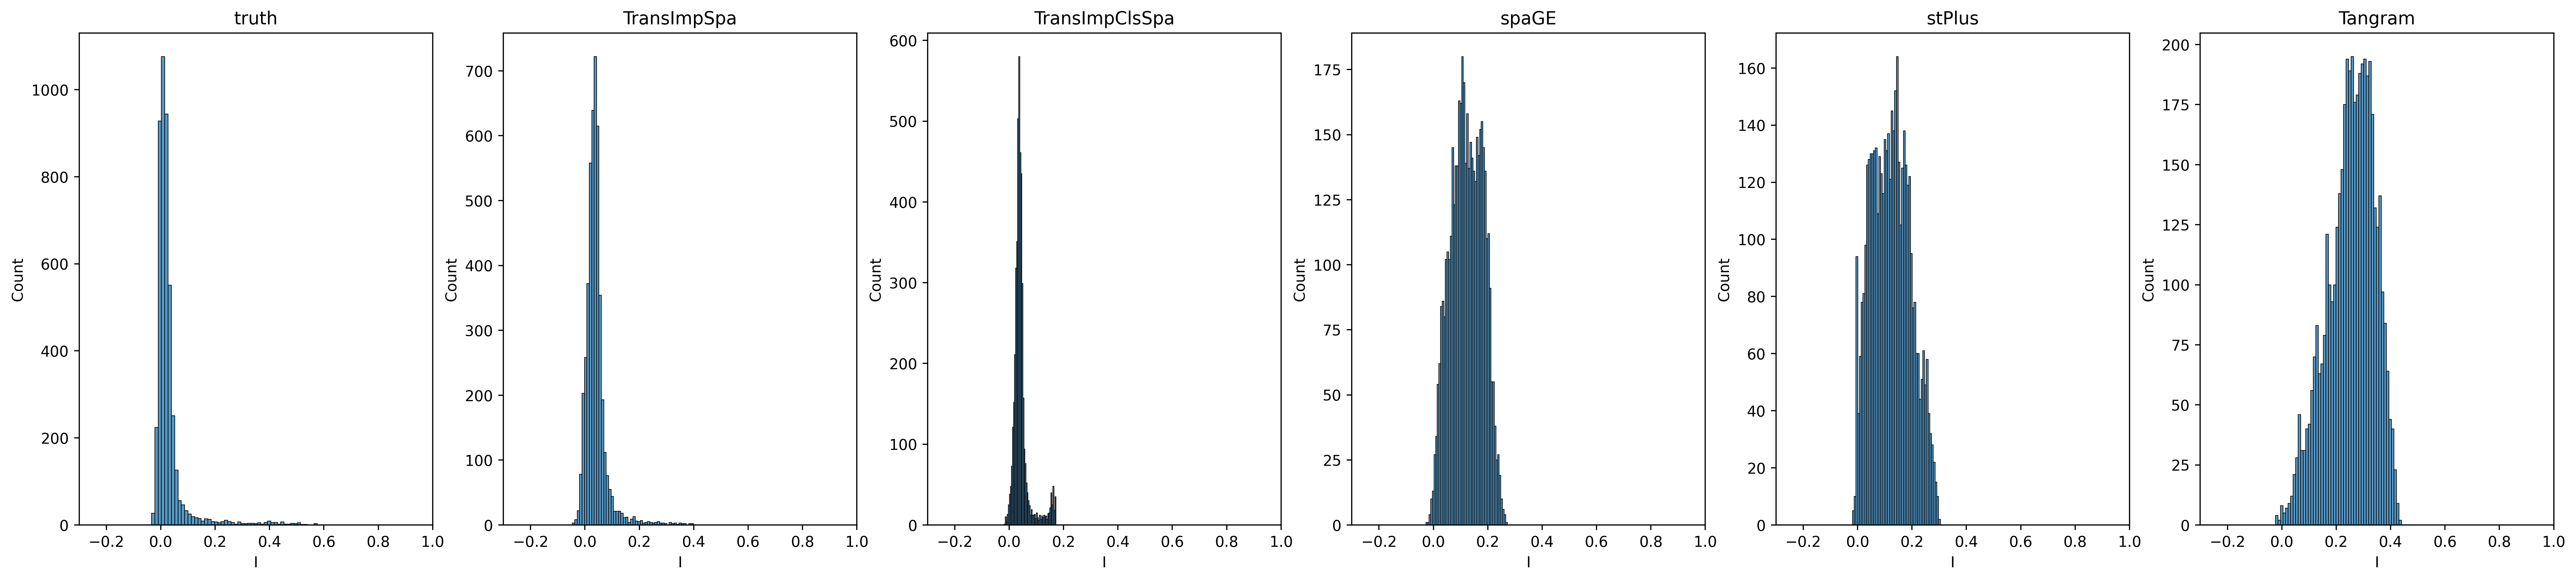

In [9]:
plt.rcParams["figure.dpi"] = 380
plt.rcParams["figure.figsize"] = (30, 6)
fig, axs = plt.subplots(1, 6)
for ax, method in zip(axs, ['truth', 'TransImpSpa', 'TransImpLR', 'spaGE', 'stPlus', 'Tangram']):
    _ax = sns.histplot(dict_adata[method].uns['moranI'].I, ax=ax, bins=50)
    _ax.set_title(f"{method}")
    _ax.set_xlim(-0.3, 1.0)

In [9]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImpLR: 0.055141
	True vs TransImpSpa: 0.002773
	True vs TransImpCls: 0.082973
	True vs TransImpClsSpa: 0.003488
	True vs spaGE: 0.016108
	True vs Tangram: 0.063428
	True vs truth: 0.000000


In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle

from scipy import sparse
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
from plotting import plot_curve_MI, plot_curve_SPARKX, plot_curve_SDM
import warnings

color = ['#c780e8', '#845B53', '#D684BD', '#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2',  ]
methods = ['truth', 'TransImpSpa', 'TransImpClsSpa', 'TransImpLR', 'TransImpCls', 'spaGE', 'stPlus',  'Tangram', ]
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [11]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}, 'pval':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            genes=imp_adata.var_names,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['pval'][method] = pd.Series(imp_adata.uns['moranI'].pval_norm, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


In [12]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr

,Tangram,TransImpCls,TransImpClsSpa,TransImpLR,TransImpSpa,spaGE,stPlus,truth
0610010F05Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,4.175299e-01
1110046J04Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.737710e-01
1190005I06Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.160905e-06
1200007C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.595635e-01
1500009L16Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,4.413797e-01
...,...,...,...,...,...,...,...,...
mt-Nd2,0.228183,0.254256,0.217527,0.181255,0.008078,0.199566,NaN,0.000000e+00
mt-Nd3,0.114896,0.340576,0.204106,0.169834,0.006575,0.194868,NaN,0.000000e+00
mt-Nd4,0.114896,0.484105,0.199557,0.149000,0.001728,0.131116,NaN,0.000000e+00
mt-Nd4l,0.082141,0.412611,0.193407,0.110981,0.001529,0.070164,NaN,5.249617e-04


(TransImpSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (1897/3546)
(TransImpClsSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (2427/3546)
(TransImpLR) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3352/3546)
(TransImpCls) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3522/3546)
(spaGE) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3351/3546)
(stPlus) Valid genes: 3528/4517, Ground Sig/Total (804/3528), Pred Sig/total (0/3528)
(Tangram) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3517/3546)


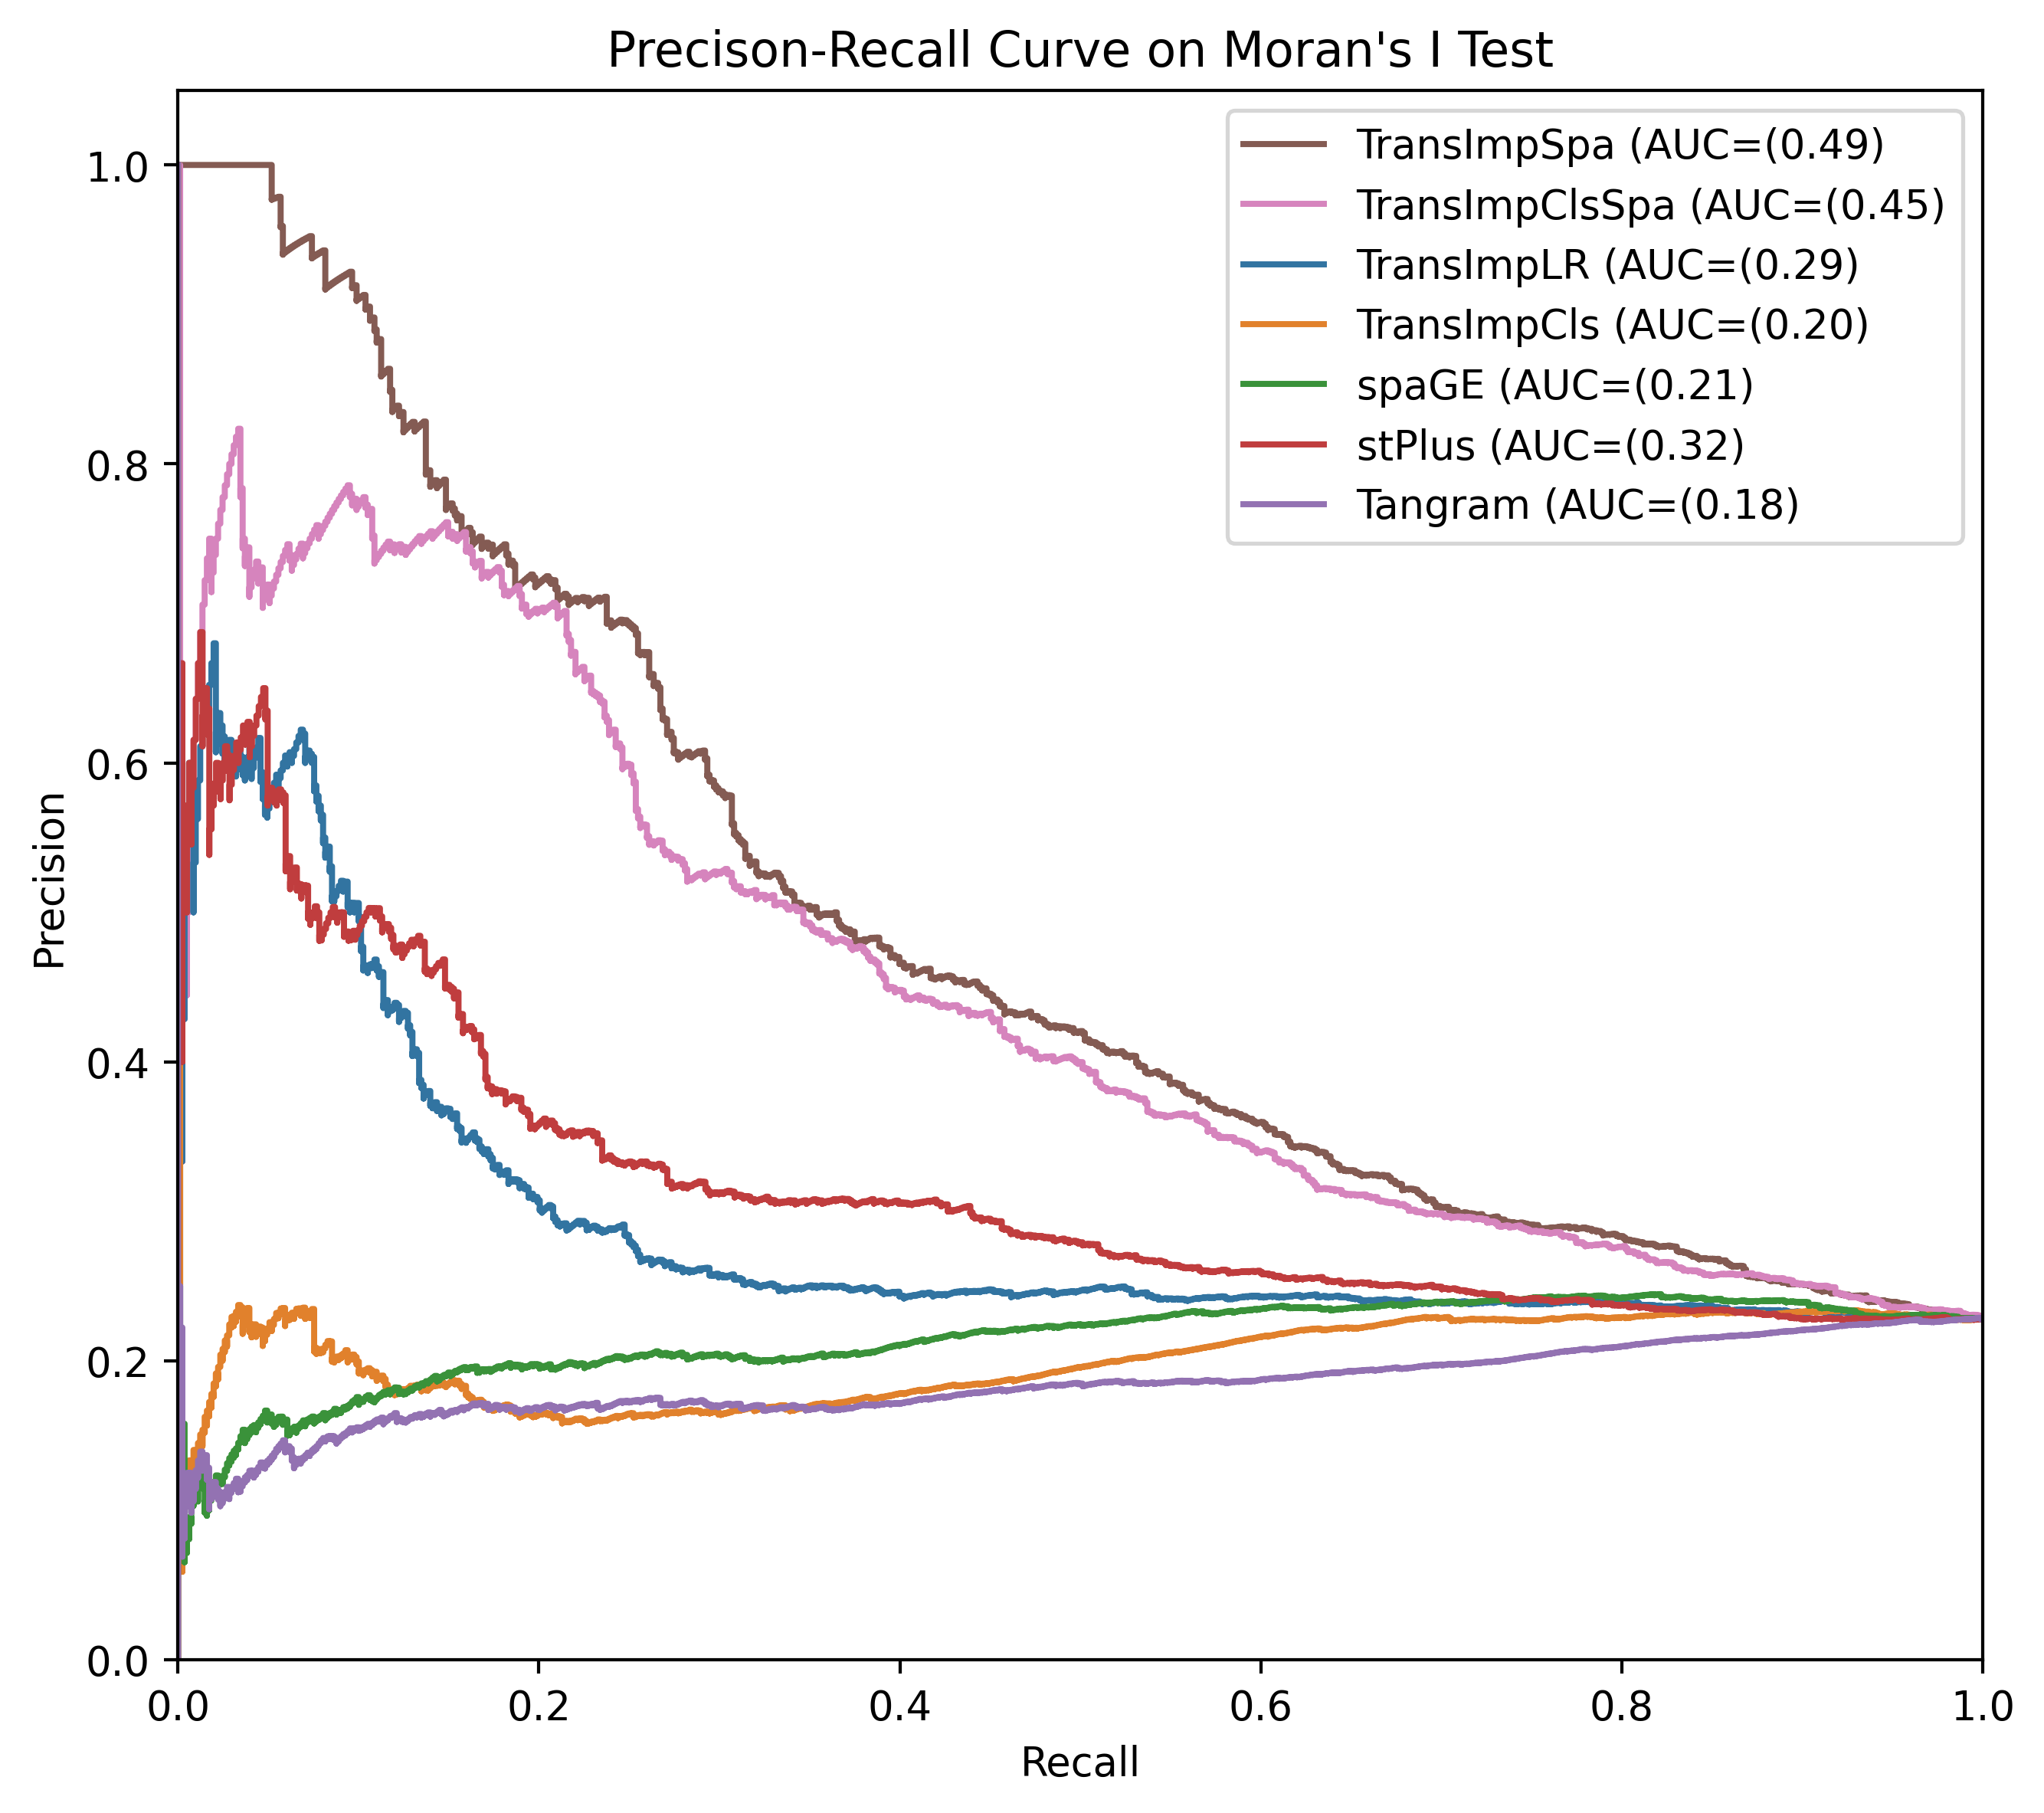

In [13]:
plot_curve_MI(df_corr, 
              df_I, 
              df_fdr, 
              methods, 
              color, 
              "prec_rec",
              thred=thred, 
              excluded_items={'truth'})

(TransImpSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (1897/3546)
(TransImpClsSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (2427/3546)
(TransImpLR) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3352/3546)
(TransImpCls) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3522/3546)
(spaGE) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3351/3546)
(stPlus) Valid genes: 3528/4517, Ground Sig/Total (804/3528), Pred Sig/total (0/3528)
(Tangram) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3517/3546)


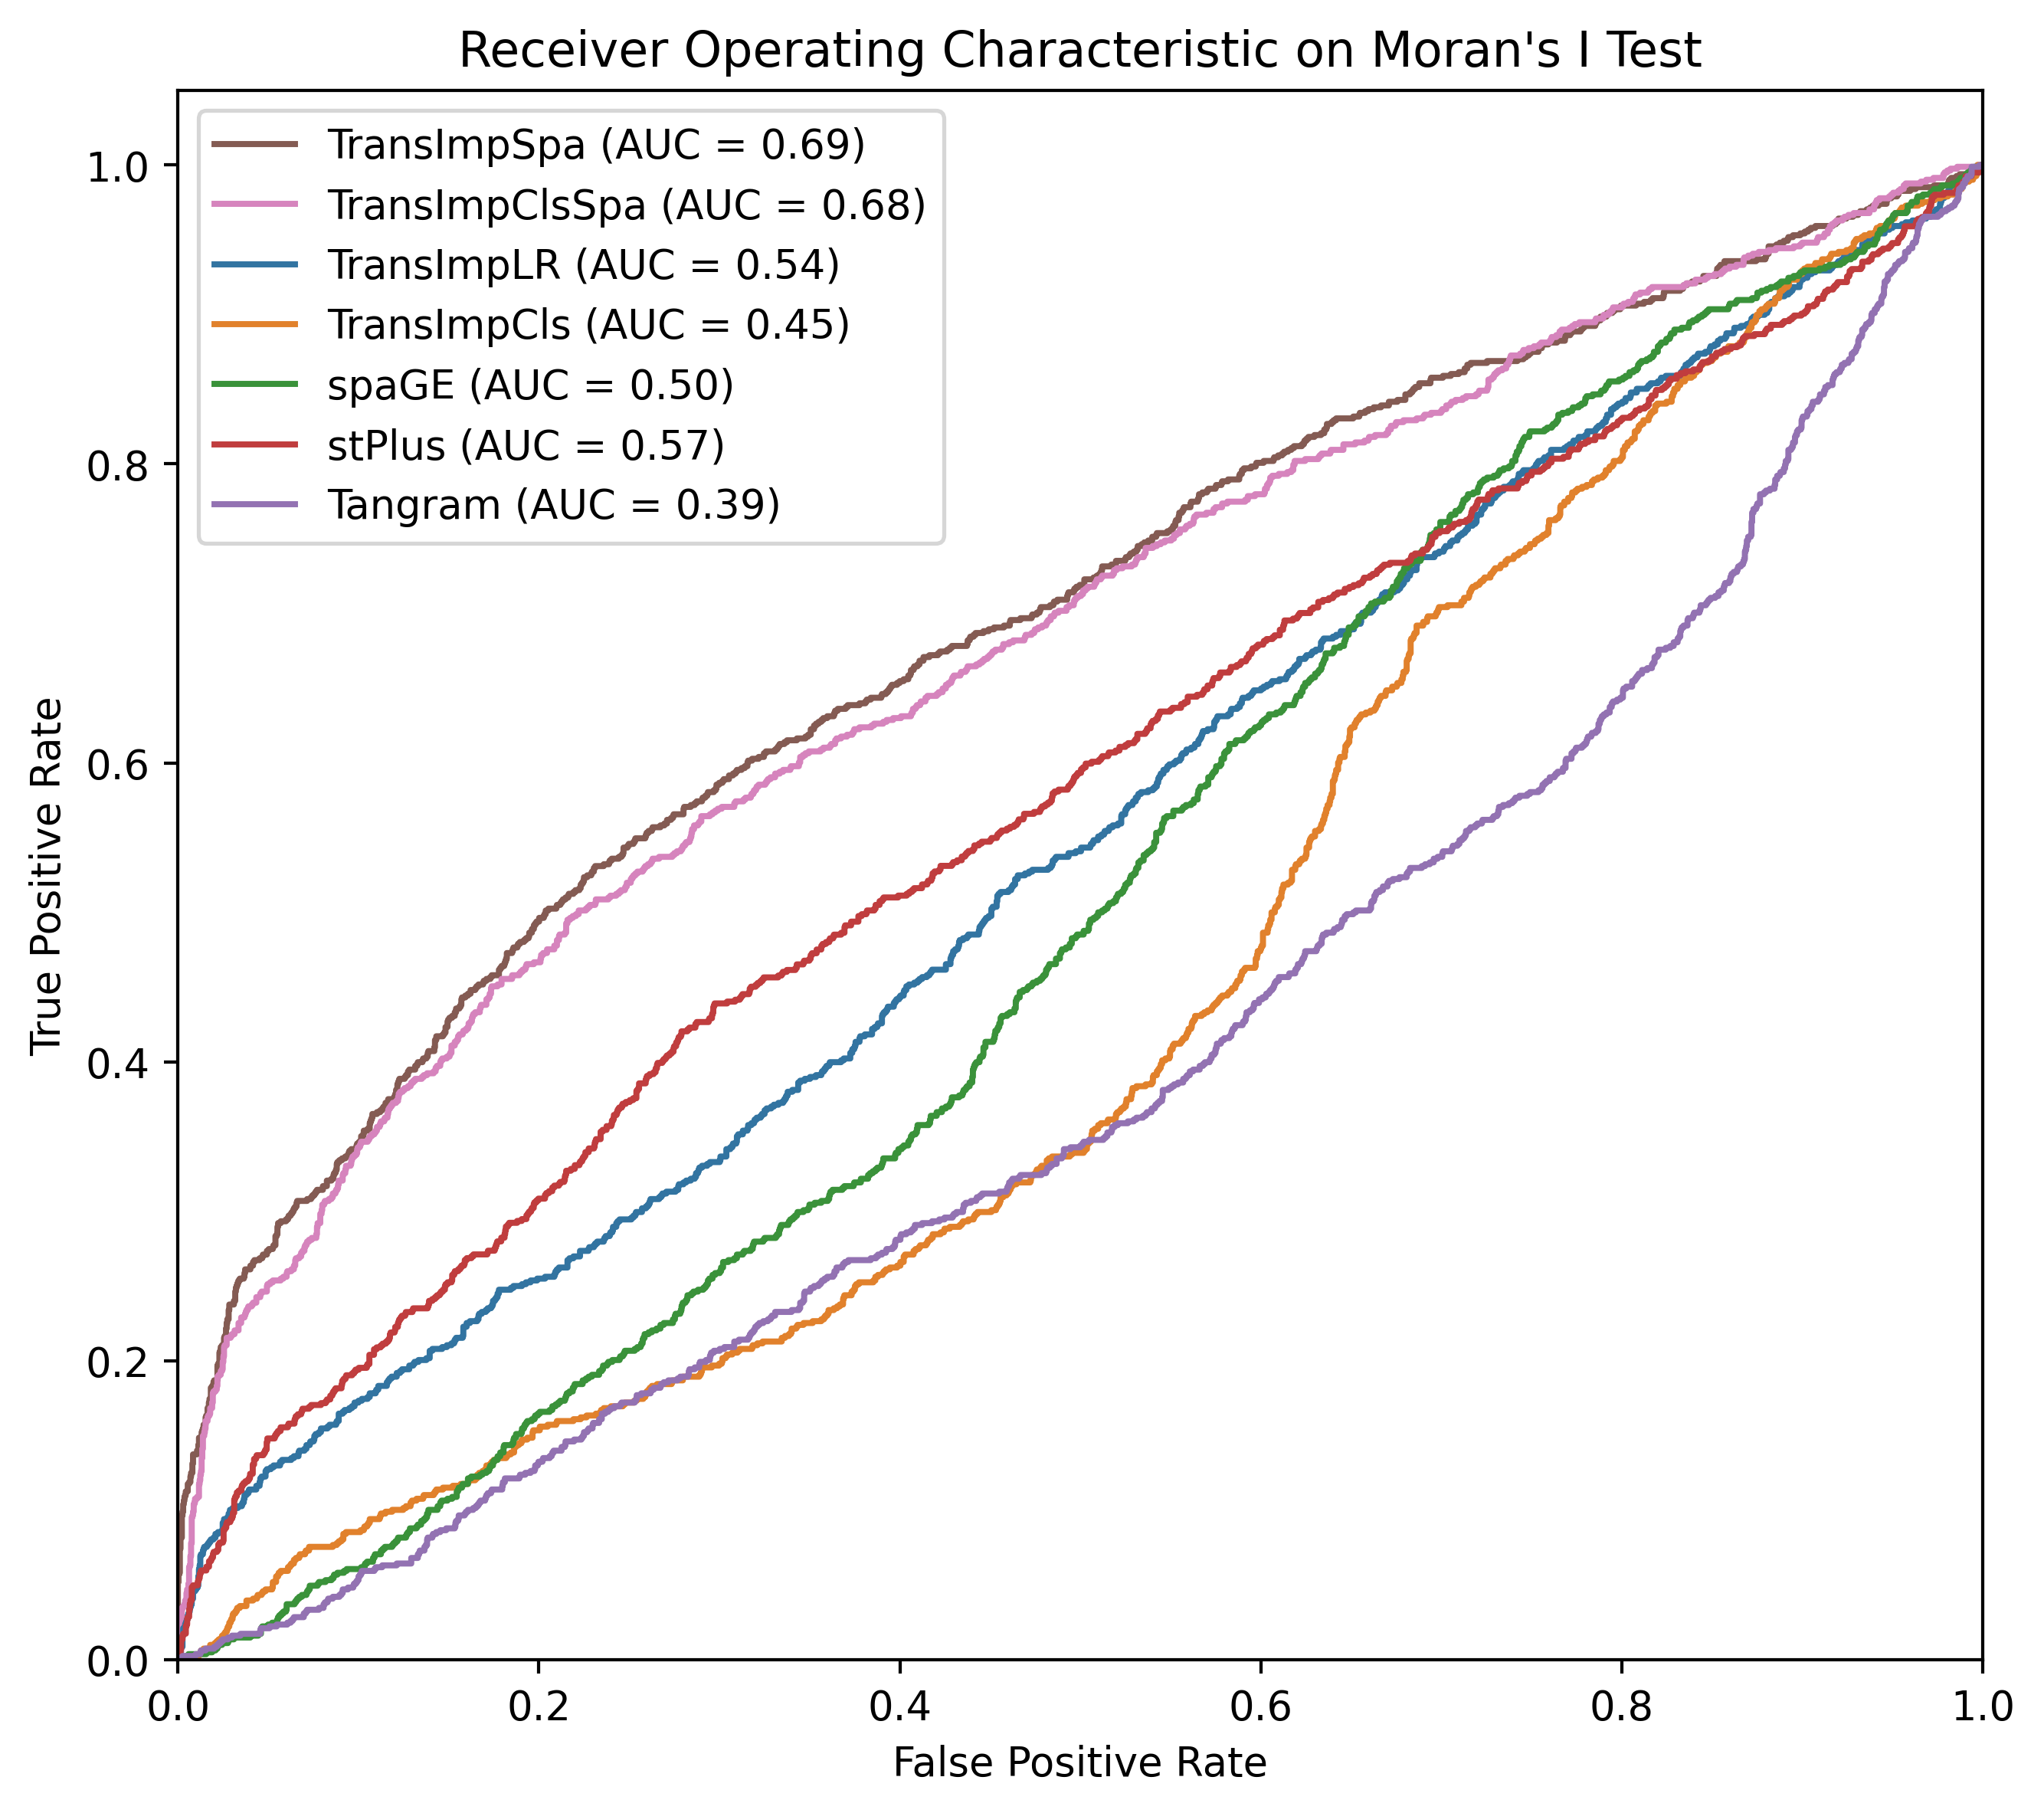

In [14]:
plot_curve_MI(df_corr, 
              df_I, 
              df_fdr, 
              methods, 
              color, 
              "roc",
              thred=thred, 
              excluded_items={'truth'})

In [15]:
# !Rscript sparkX.r
!source /home/cqiao/.bashrc; ~/R/bin/Rscript sparkX.r mouseliver5fold

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 
[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2110 
## number of total genes: 4517 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2110 
## number of total genes: 4483 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Test

In [16]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_adjpvals
    

truth
TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram


,truth,TransImpSpa,TransImpClsSpa,TransImpLR,TransImpCls,spaGE,stPlus,Tangram
X0610010F05Rik,1.000000e+00,8.830175e-10,6.828600e-10,6.469265e-20,1.628821e-31,3.139118e-08,1.192953e-02,7.660956e-23
X1110046J04Rik,1.000000e+00,1.000000e+00,2.843632e-05,2.835872e-04,3.398522e-17,2.887310e-01,4.311576e-04,1.743169e-29
X1190005I06Rik,1.148201e-01,2.554044e-08,1.122237e-11,8.176342e-16,2.024910e-19,2.589219e-02,1.181853e-14,2.925939e-08
X1200007C13Rik,1.000000e+00,7.250686e-06,5.030059e-08,1.958202e-03,8.701566e-22,4.980999e-04,7.085198e-01,9.330026e-23
X1500009L16Rik,1.000000e+00,3.983884e-03,1.914736e-03,1.159220e-03,1.001294e-10,4.478716e-06,1.221423e-04,1.003131e-16
...,...,...,...,...,...,...,...,...
mt.Nd2,7.752673e-99,9.481708e-18,1.754877e-12,7.578880e-29,2.385435e-35,1.071368e-17,2.079425e-09,7.440010e-32
mt.Nd3,4.156607e-22,2.760993e-11,4.097654e-12,9.739045e-31,1.067670e-35,1.126847e-05,1.000000e+00,1.113219e-27
mt.Nd4,1.117396e-83,1.687665e-20,1.173480e-12,3.026798e-31,3.956386e-35,4.108628e-14,4.259179e-13,1.320786e-31
mt.Nd4l,3.144234e-04,1.262065e-14,2.183077e-11,5.442376e-27,3.026009e-32,1.226310e-09,4.024504e-10,8.662117e-27


(TransImpSpa) Valid genes: 4517/4517
(TransImpClsSpa) Valid genes: 4517/4517
(TransImpLR) Valid genes: 4517/4517
(TransImpCls) Valid genes: 4517/4517
(spaGE) Valid genes: 4517/4517
(stPlus) Valid genes: 4517/4517
(Tangram) Valid genes: 4517/4517


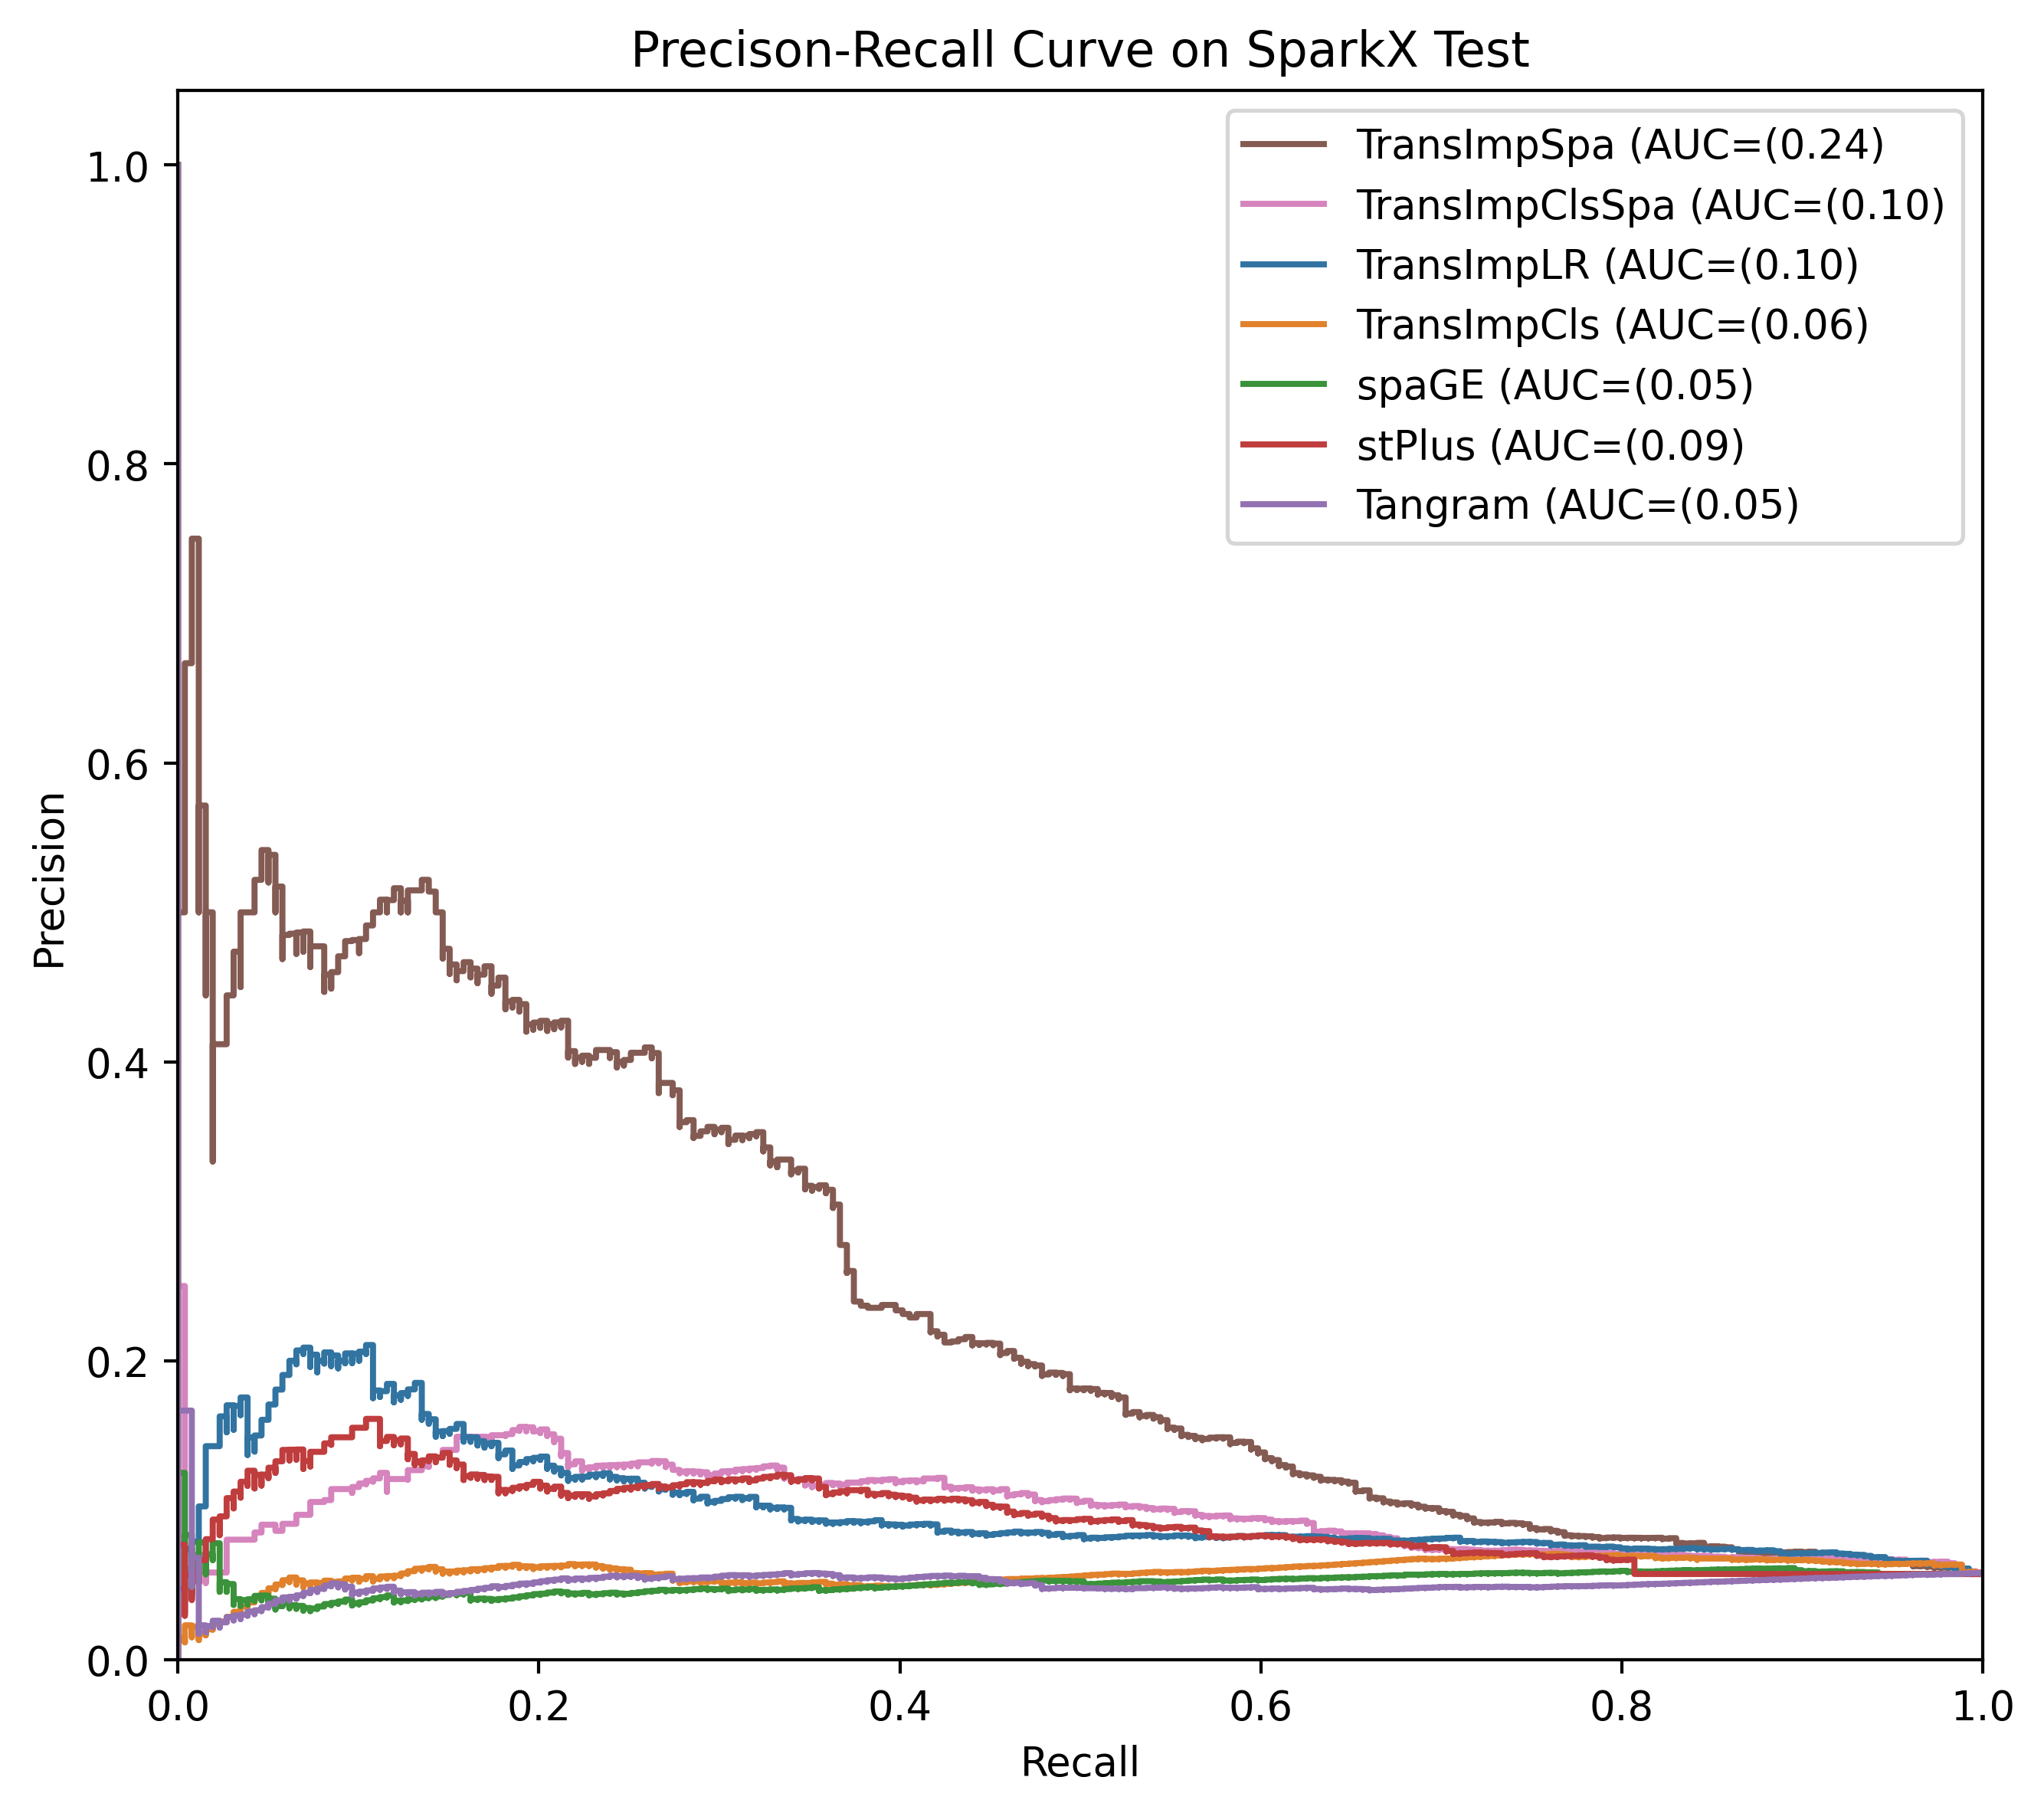

In [17]:
plot_curve_SPARKX(
                  df_sparkx_adjpvals,
                  methods, 
                  color, 
                  'prec_rec',
                  thred=0.01,
                  excluded_items={'truth'})

(TransImpSpa) Valid genes: 4517/4517
(TransImpClsSpa) Valid genes: 4517/4517
(TransImpLR) Valid genes: 4517/4517
(TransImpCls) Valid genes: 4517/4517
(spaGE) Valid genes: 4517/4517
(stPlus) Valid genes: 4517/4517
(Tangram) Valid genes: 4517/4517


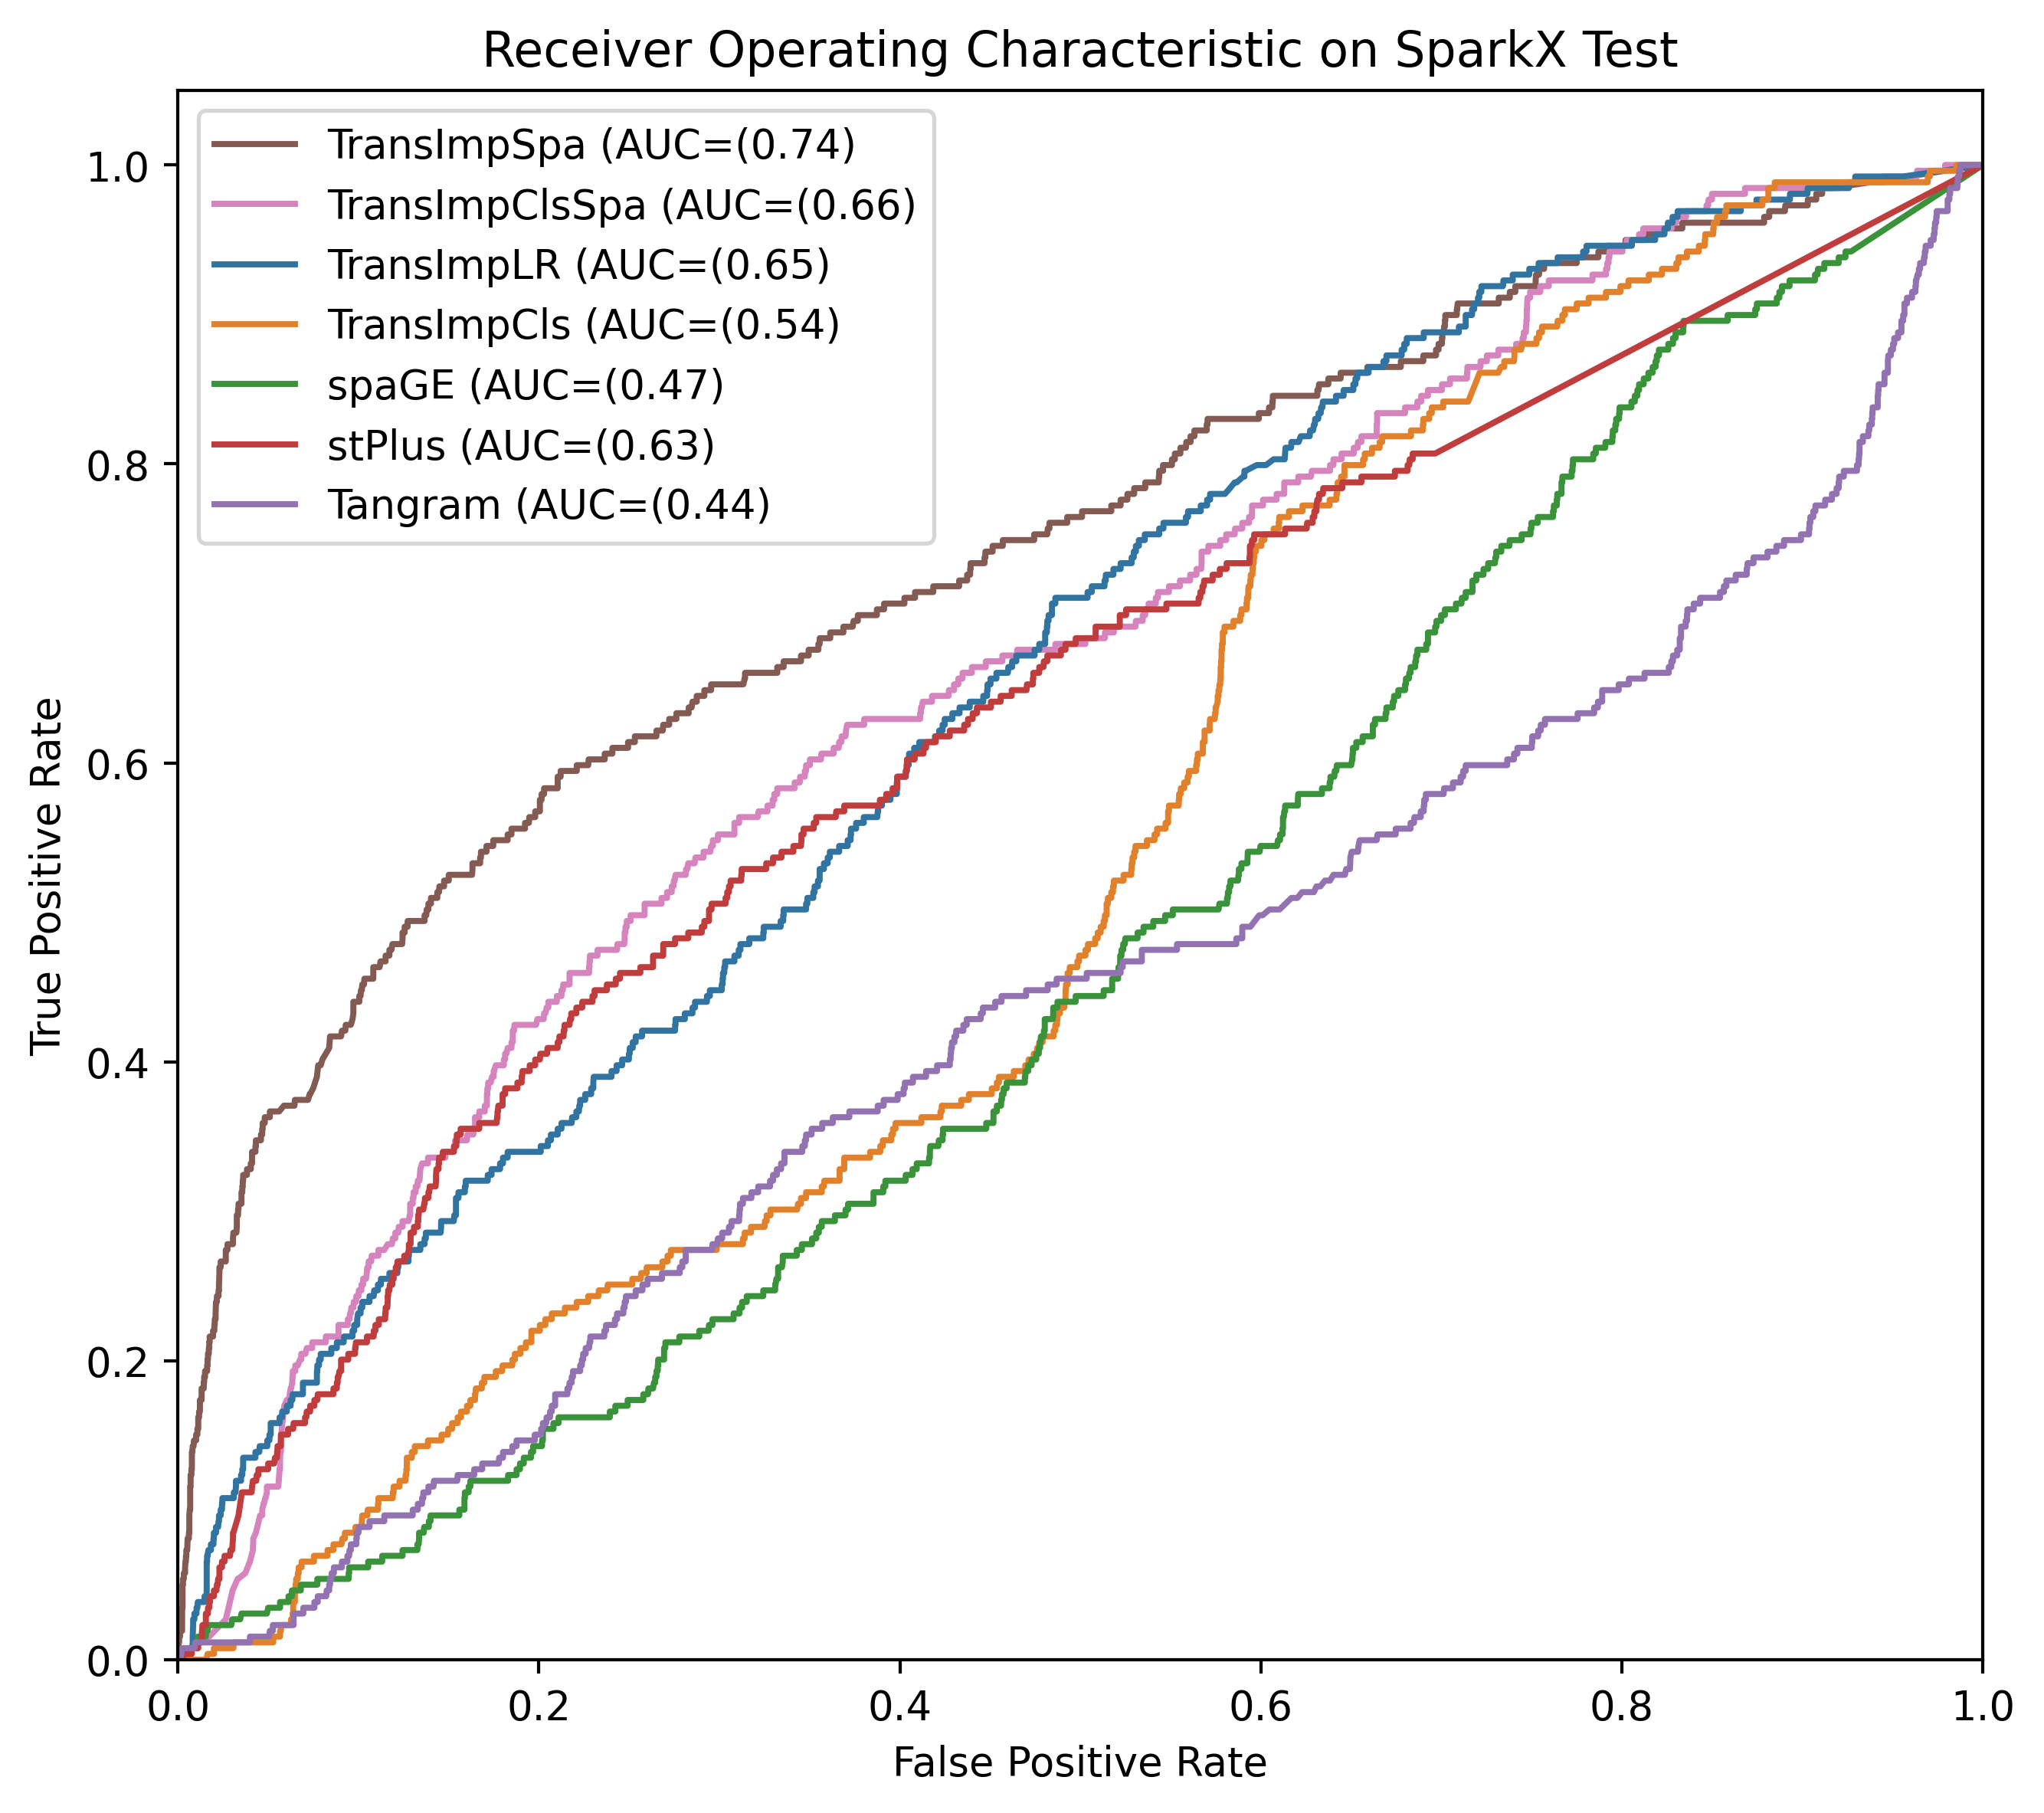

In [18]:
plot_curve_SPARKX(
                  df_sparkx_adjpvals,
                  methods, 
                  color, 
                  'roc',
                  thred=0.01,
                  excluded_items={'truth'})
                  

In [19]:
from scipy import sparse
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
def read_data(imp_adatas):
    with open(pre_datapath, 'rb') as infile:
        spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)
    adatas = {}
    for method in methods:
        adatas[method] = merge_data(imp_adatas[method], spa_adata)
        adatas[method].obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    return adatas

m_adatas = read_data(dict_adata)

Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517


In [20]:
for md in m_adatas:
    spatialdm(m_adatas[md], spec, 50)    

332 332
(323, 10)
332 332
(323, 10)
332 332
(323, 10)
332 332
(323, 10)
332 332
(323, 10)
332 332
(323, 10)
332 332
(323, 12)
332 332
(323, 10)


In [21]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(m_adatas, outfile)

TransImpSpa # 214 pairs, # sig pairs: (Truth): 82, (Preds) 190
TransImpClsSpa # 214 pairs, # sig pairs: (Truth): 82, (Preds) 196
TransImpLR # 214 pairs, # sig pairs: (Truth): 82, (Preds) 202
TransImpCls # 214 pairs, # sig pairs: (Truth): 82, (Preds) 204
spaGE # 214 pairs, # sig pairs: (Truth): 82, (Preds) 160
stPlus # 214 pairs, # sig pairs: (Truth): 82, (Preds) 121
Tangram # 214 pairs, # sig pairs: (Truth): 82, (Preds) 201


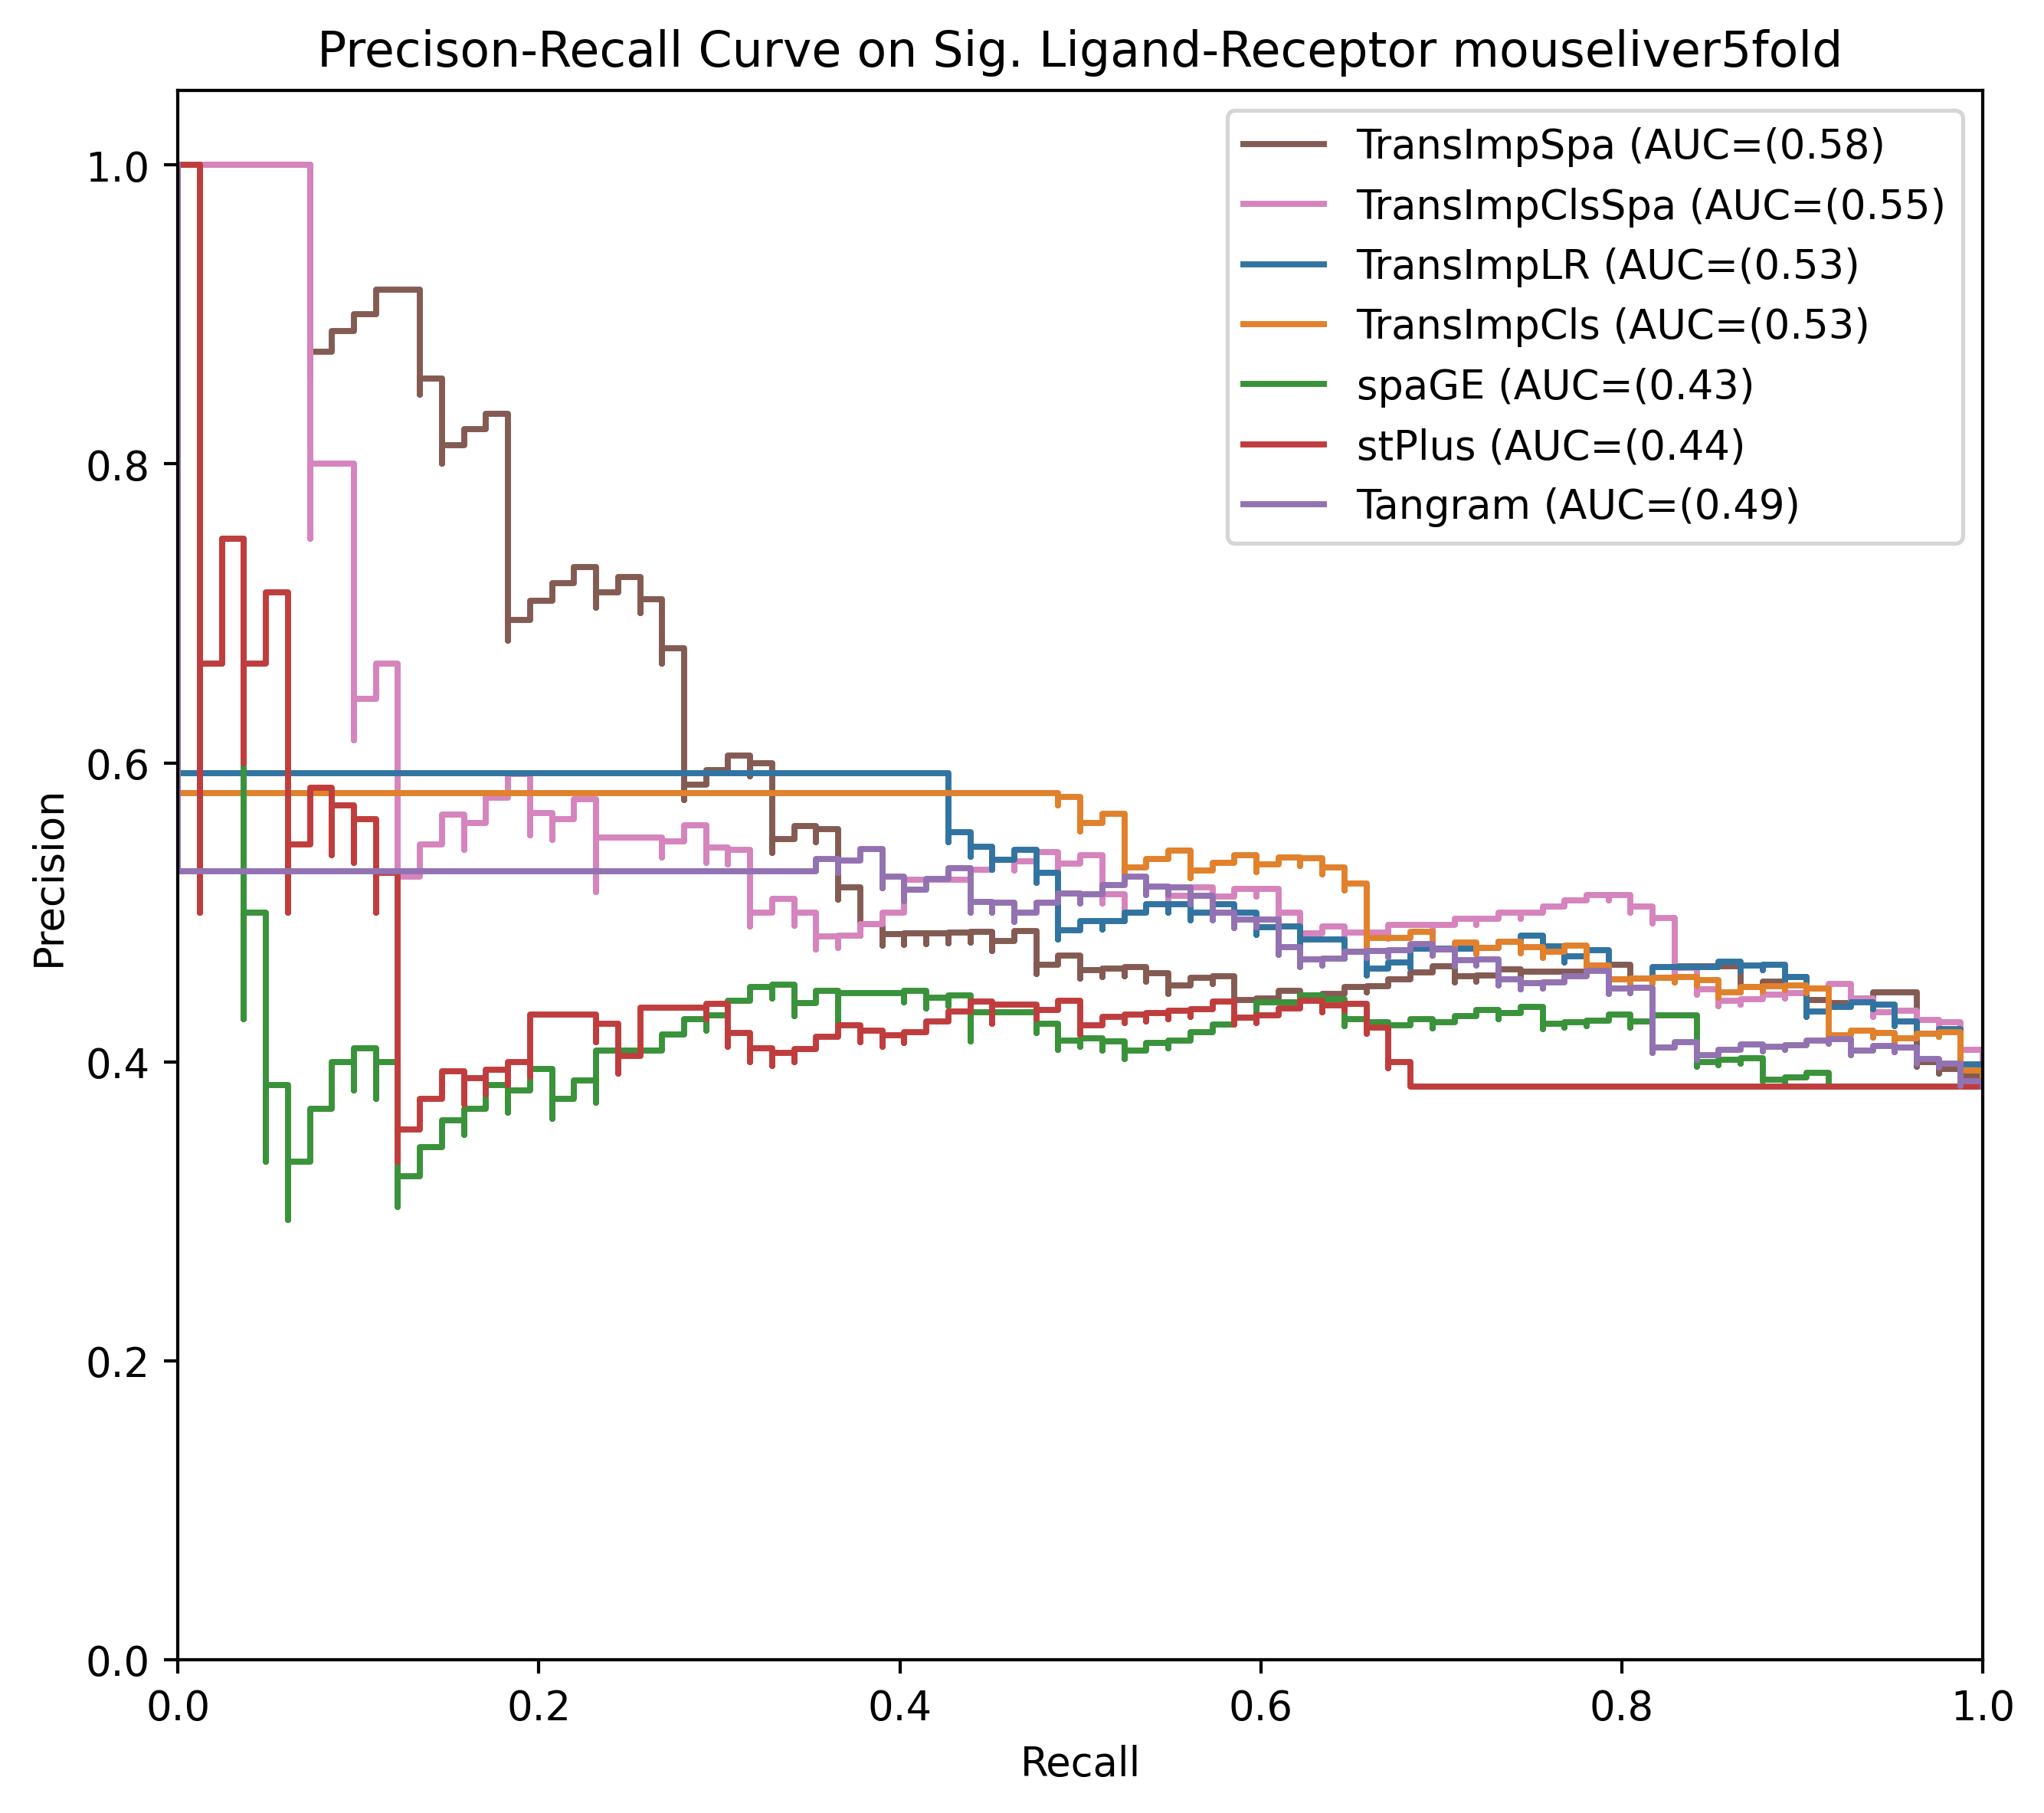

In [22]:
plot_curve_SDM(m_adatas, 
               ST_name, 
               methods, 
               color, 
               'prec_rec',
               thred=0.01,
               excluded_items={'truth'})


TransImpSpa # 214 pairs, # sig pairs: (Truth): 82, (Preds) 190
TransImpClsSpa # 214 pairs, # sig pairs: (Truth): 82, (Preds) 196
TransImpLR # 214 pairs, # sig pairs: (Truth): 82, (Preds) 202
TransImpCls # 214 pairs, # sig pairs: (Truth): 82, (Preds) 204
spaGE # 214 pairs, # sig pairs: (Truth): 82, (Preds) 160
stPlus # 214 pairs, # sig pairs: (Truth): 82, (Preds) 121
Tangram # 214 pairs, # sig pairs: (Truth): 82, (Preds) 201


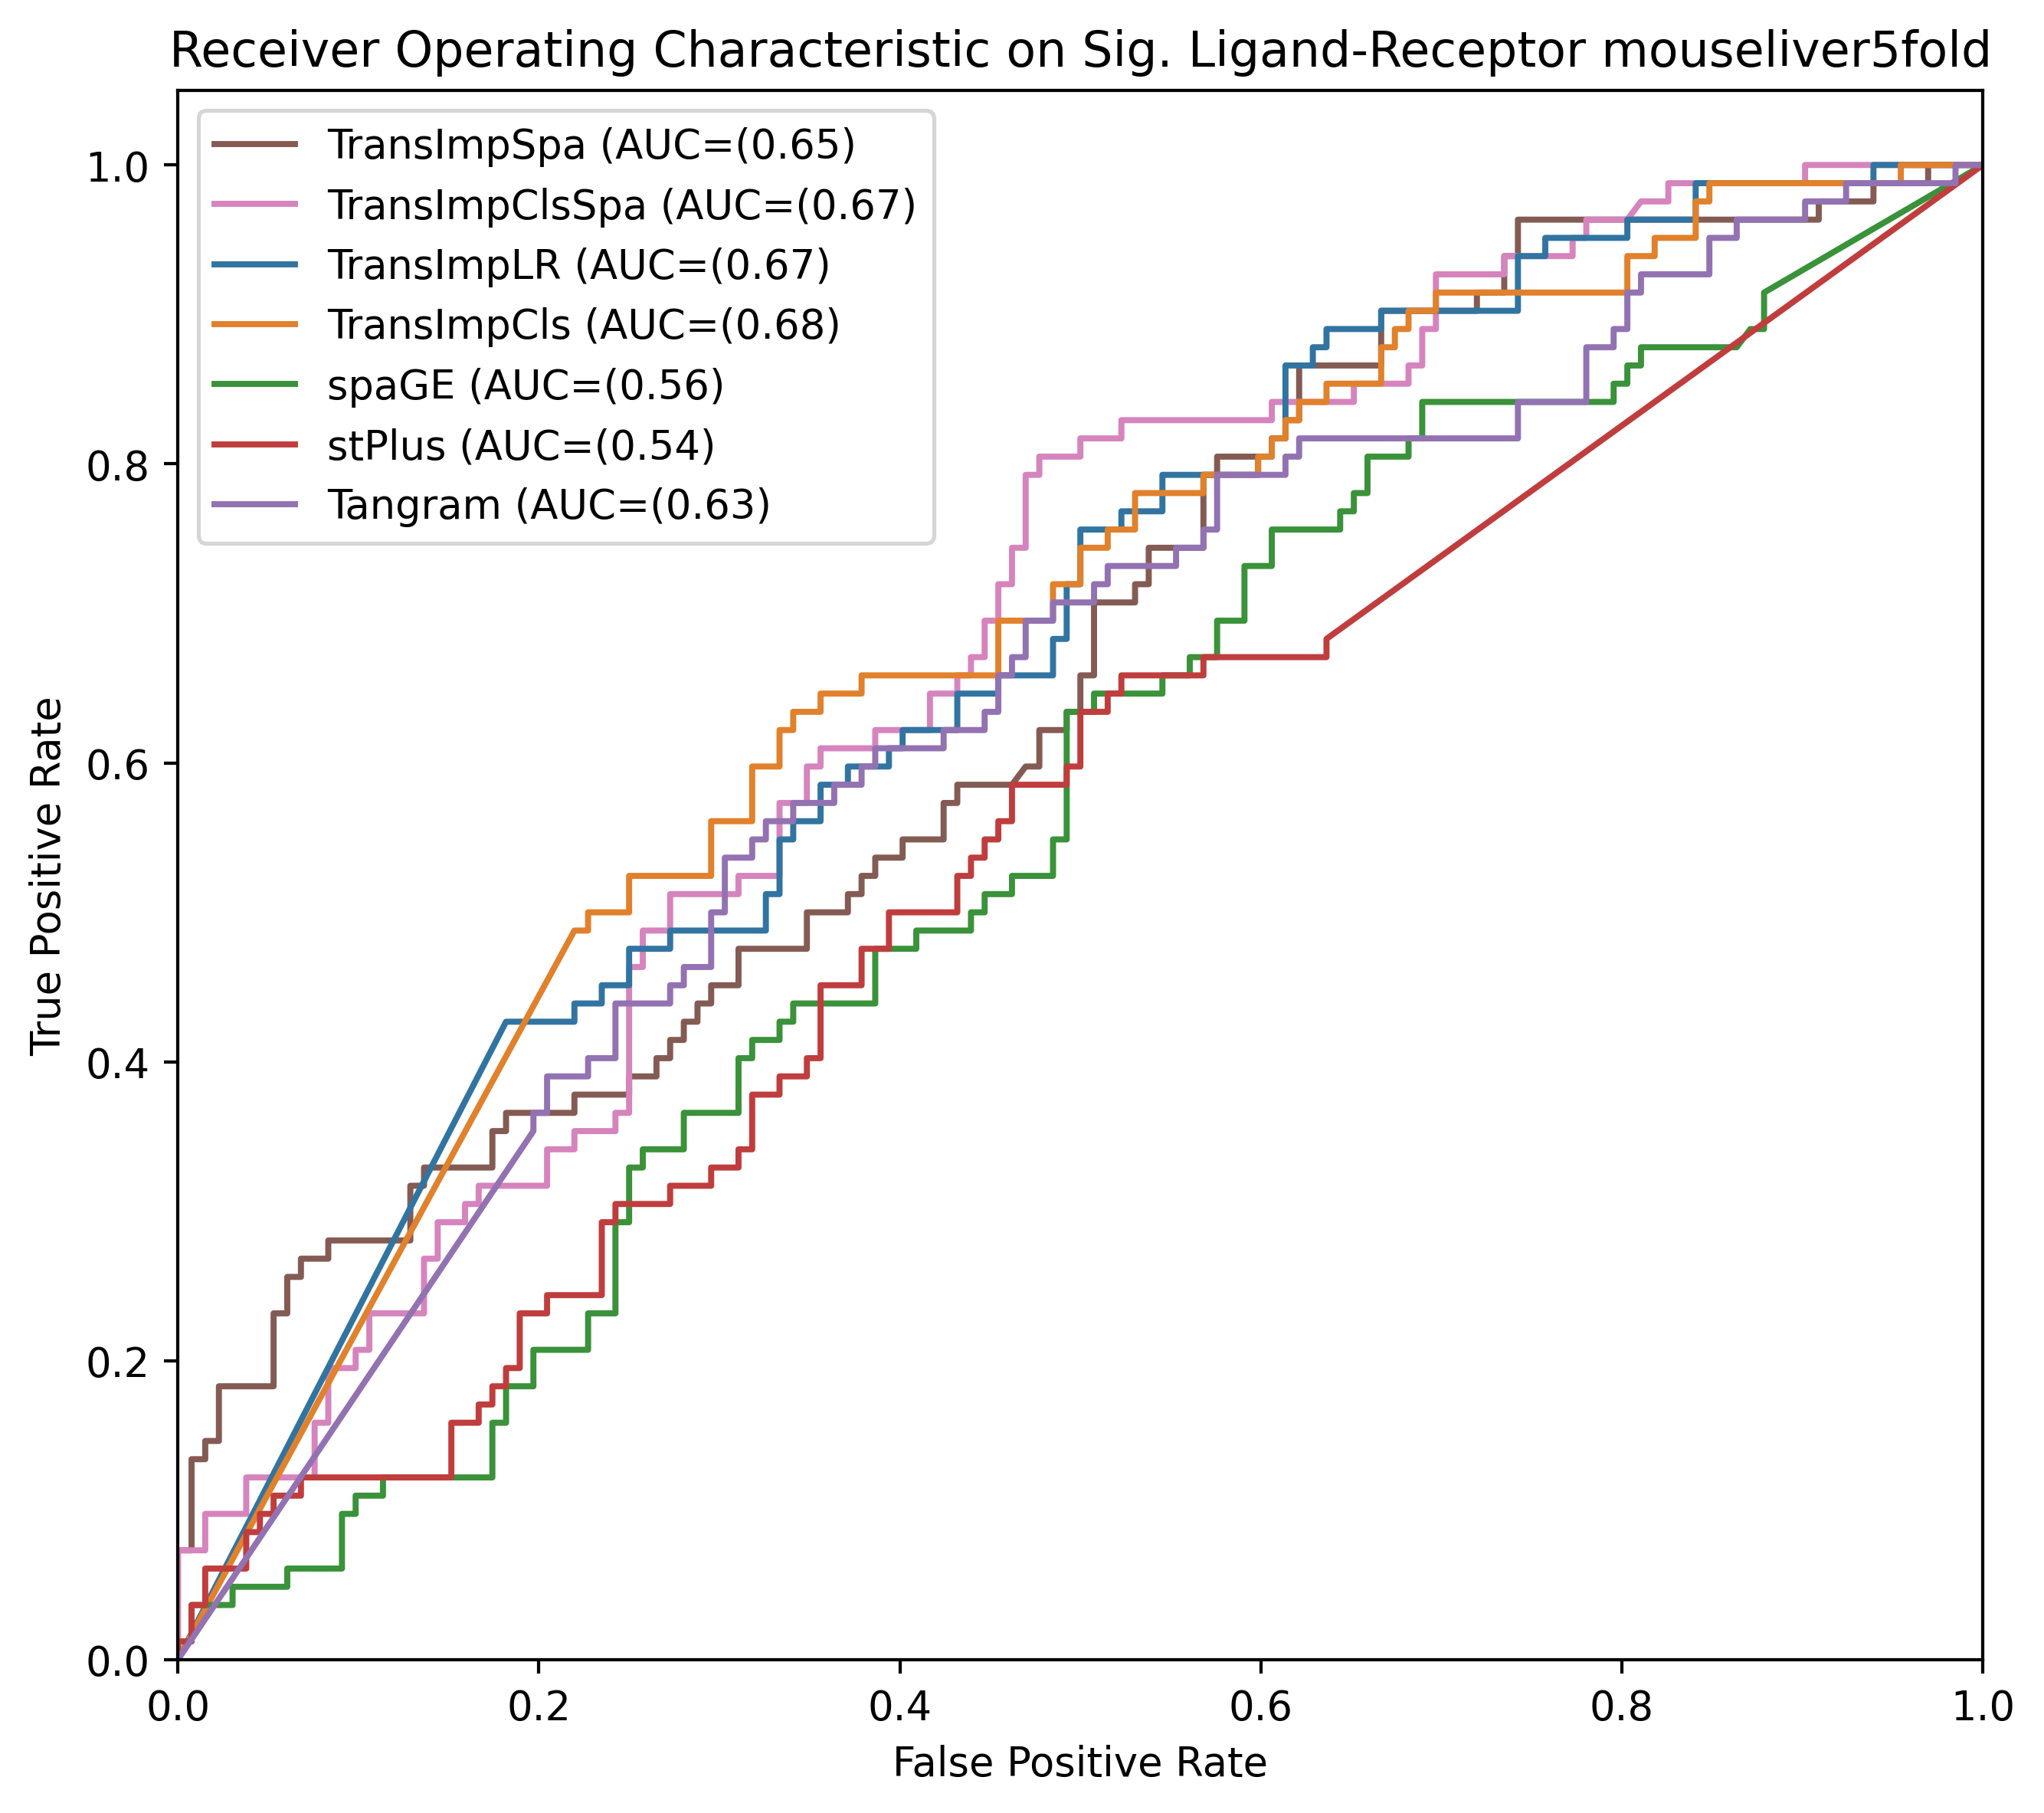

In [23]:
plot_curve_SDM(m_adatas, 
               ST_name, 
               methods, 
               color, 
               'roc',
               thred=0.01,
               excluded_items={ 'truth'})
